In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/grounded_reports_20240819.json
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/master_table.csv/master_table.csv
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/18170444478498428890131546156984035709_134g5w.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/62906280474335528886711002923566341388_m76jw7.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/173017479468926515377552295687060543889-2_zukli8.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/339855222351391302353935714780946761951_wlpisz.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/65769018201185758078108695660212988067_xi2eq6.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Pad

In [2]:
# Cell 1 — Imports and environment
import os
import sys
import math
import time
import json
from typing import Optional, Tuple, Dict, Any, List

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# plotting
import matplotlib.pyplot as plt

# UI
import gradio as gr

# disable tokenizer parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# set deterministic-ish seeds (not fully reproducible when using cudnn.benchmark)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# Cell 2 — Load CSV
csv_path = "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/master_table.csv/master_table.csv"
assert os.path.exists(csv_path), f"CSV path not found: {csv_path}"

df = pd.read_csv(csv_path, low_memory=False)
print("File loaded:", csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(3))


File loaded: /kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/master_table.csv/master_table.csv
Shape: (8787, 23)
Columns: ['StudyID', 'ImageID', 'label', 'boxes_count', 'extra_boxes_count', 'locations', 'prior_study', 'progression_status', 'prior_imageID', 'sentence_en', 'sentence_es', 'study_is_benchmark', 'study_is_validation', 'split', 'PatientID', 'patient_is_benchmark', 'PatientBirth', 'PatientSex_DICOM', 'StudyDate_DICOM', 'StudyDate', 'PatientAge', 'label_group', 'Year']


StudyID                                            ImageID  \
0  2.51488E+38  251488034557732338959601580328898734705_wigcpj...   
1  2.51488E+38  251488034557732338959601580328898734705_wigcpj...   
2  1.09876E+38  109876241481532572619807710001909166420_dln48o...   

                         label  boxes_count  extra_boxes_count  \
0    apical pleural thickening            2                  2   
1  costophrenic angle blunting            0                  0   
2                       Normal            0                  0   

                                           locations  prior_study  \
0                                        ['pleural']        False   
1  ['left costophrenic angle', 'costophrenic angle']        False   
2                                                 []         True   

  progression_status                                      prior_imageID  \
0                NaN                                                NaN   
1                NaN                                                NaN   
2                NaN  216840111366964013217898866992011328080029653_...   

                                         sentence_en  ...  split  \
0               Minimal biapical pleural thickening.  ...   test   
1  Slight blunting of the posterior left costophr...  ...   test   
2                                                NaN  ...  train   

      PatientID  patient_is_benchmark PatientBirth  PatientSex_DICOM  \
0  2.430900e+38                  True         1950                 F   
1  2.430900e+38                  True         1950                 F   
2  2.022000e+38                  True         1947                 M   

   StudyDate_DICOM  StudyDate PatientAge         label_group  Year  
0         20141114       2014         64  pleural thickening  2014  
1         20141114       2014         64    pleural effusion  2014  
2         20140819       2014         67              Normal  2014  

[3 rows x 23 columns]

In [4]:
# Cell 3 — Normalize text & label columns and encode labels
# Identify text column (prefer Spanish)
text_col = None
for c in ["sentence_es", "Report", "sentence_en"]:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise KeyError("No text column found. Expected 'sentence_es' or 'Report' or 'sentence_en' in CSV.")

label_col = "label" if "label" in df.columns else None
if label_col is None:
    raise KeyError("No 'label' column found in CSV.")

# Keep only rows with text and labels
df = df.dropna(subset=[text_col, label_col]).reset_index(drop=True)
print("After dropping NA rows:", len(df))

# Normalize label text
df[label_col] = df[label_col].astype(str).str.strip()

# Create label_encoded
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df[label_col].astype(str))
print("Number of classes:", df["label_encoded"].nunique())
print("Sample labels:", list(le.classes_)[:10])


After dropping NA rows: 7331
Number of classes: 154
Sample labels: ['Chilaiditi sign', 'NSG tube', 'abnormal foreign body', 'abscess', 'adenopathy', 'air bronchogram', 'air fluid level', 'air trapping', 'alveolar pattern', 'aortic aneurysm']


In [5]:
# Cell 4 — Detect image folders & build image_path column
base_candidates = [
    "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR",
    "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/PadChest_GR_progression_prior_studies/PadChest_GR_progression_prior_studies"
]
available_files = []
for base in base_candidates:
    if os.path.exists(base):
        files = os.listdir(base)
        print(f"Found {len(files)} files in {base}")
        available_files += [os.path.join(base, f) for f in files]

# Make a helper to find file by ImageID (with or without extension)
def find_image_path(imgid: str, bases=base_candidates):
    if pd.isna(imgid):
        return None
    imgid_str = str(imgid)
    # If the CSV already includes extension, try direct
    if imgid_str.lower().endswith((".png", ".jpg", ".jpeg")):
        for base in bases:
            p = os.path.join(base, imgid_str)
            if os.path.exists(p):
                return p
    # else try common extensions
    for ext in [".png", ".jpg", ".jpeg"]:
        candidate = imgid_str if imgid_str.endswith(ext) else imgid_str + ext
        for base in bases:
            p = os.path.join(base, candidate)
            if os.path.exists(p):
                return p
    # try exact file names in folders
    for base in bases:
        p = os.path.join(base, imgid_str + ".png")
        if os.path.exists(p):
            return p
    return None

# Build image_path column
if "ImageID" not in df.columns:
    raise KeyError("CSV missing 'ImageID' column")
df["image_path"] = df["ImageID"].apply(lambda x: find_image_path(x, base_candidates))
print("Sample image_path values:")
print(df["image_path"].head())

# Filter rows that actually resolved an image file
found = df["image_path"].notna().sum()
print(f"Images found for {found}/{len(df)} records")
df = df[df["image_path"].notna()].reset_index(drop=True)


Found 4555 files in /kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR
Found 1446 files in /kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/PadChest_GR_progression_prior_studies/PadChest_GR_progression_prior_studies
Sample image_path values:
0    /kaggle/input/bimcv-padchest-gr-rithvik-editio...
1    /kaggle/input/bimcv-padchest-gr-rithvik-editio...
2    /kaggle/input/bimcv-padchest-gr-rithvik-editio...
3    /kaggle/input/bimcv-padchest-gr-rithvik-editio...
4    /kaggle/input/bimcv-padchest-gr-rithvik-editio...
Name: image_path, dtype: object
Images found for 7331/7331 records


In [6]:
# Cell 5 — Optionally create binary target (normal vs abnormal) if you want
# If you want multiclass, skip; user asked both—we will support both in model/train selection.
normal_keywords = ['normal', 'no finding', 'healthy', 'no abnormality']
df["label_lower"] = df[label_col].astype(str).str.lower()
df["binary_label"] = df["label_lower"].apply(lambda x: 0 if any(k in x for k in normal_keywords) else 1)

# If there are classes with only 1 sample, warn and optionally merge or drop them.
class_counts = df["label_encoded"].value_counts()
few = class_counts[class_counts < 2]
if len(few) > 0:
    print(f"Warning: {len(few)} classes have fewer than 2 samples; stratified split may fail.")
    # Option choices: drop rare classes OR switch to non-stratified split


In [7]:
# Cell 6 — Train/val split (try stratify, fallback to simple split)
from sklearn.model_selection import train_test_split

try:
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label_encoded"])
except Exception as e:
    print("Stratified split failed:", e)
    print("Falling back to non-stratified split.")
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)

print("Train:", len(train_df), "Val:", len(val_df))


Stratified split failed: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Falling back to non-stratified split.
Train: 5864 Val: 1467


In [8]:
# Cell 7 — Tokenizer & text encoder: attempt BETO, fallback to multilingual, else use simple vocab + embedding
use_transformer_text = False
tokenizer = None
transformer_model_name = "dccuchile/bert-base-spanish-wwm-cased"  # preferred

try:
    from transformers import AutoTokenizer, AutoModel
    print("Trying to load tokenizer:", transformer_model_name)
    tokenizer = AutoTokenizer.from_pretrained(transformer_model_name, use_fast=True)
    bert_model = AutoModel.from_pretrained(transformer_model_name)
    use_transformer_text = True
    print("Loaded transformer tokenizer & model:", transformer_model_name)
except Exception as e:
    print("Primary transformer load failed:", type(e).__name__, str(e)[:200])
    # fallback 1: multilingual BERT
    try:
        transformer_model_name = "bert-base-multilingual-cased"
        tokenizer = AutoTokenizer.from_pretrained(transformer_model_name, use_fast=True)
        bert_model = AutoModel.from_pretrained(transformer_model_name)
        use_transformer_text = True
        print("Loaded multilingual tokenizer & model:", transformer_model_name)
    except Exception as e2:
        print("Multilingual load failed:", type(e2).__name__, str(e2)[:200])
        print("Falling back to trainable Bi-LSTM text encoder (simple tokenizer).")
        use_transformer_text = False
        tokenizer = None
        bert_model = None

# If transformer not available, build a simple vocab (limit vocab size to keep memory reasonable)
if not use_transformer_text:
    from collections import Counter
    texts = train_df[text_col].astype(str).str.lower().str.split().tolist()
    counter = Counter()
    for toks in texts:
        counter.update([t for t in (toks or [])])
    MAX_VOCAB = 30000
    vocab = {"<pad>": 0, "<unk>": 1}
    for w, _ in counter.most_common(MAX_VOCAB - 2):
        if w not in vocab:
            vocab[w] = len(vocab)
    print("Built simple vocab size:", len(vocab))

    def simple_tokenize(text: str, max_len=128):
        toks = str(text).lower().split()[:max_len]
        ids = [vocab.get(t, 1) for t in toks]
        if len(ids) < max_len:
            ids += [0] * (max_len - len(ids))
        return np.array(ids, dtype=np.int64)


Trying to load tokenizer: dccuchile/bert-base-spanish-wwm-cased


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded transformer tokenizer & model: dccuchile/bert-base-spanish-wwm-cased


In [9]:
# Cell 8 — Dataset & transforms
IMG_SIZE = 300
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(6),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class PadChestGRDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, transform, max_len=128, mode="fusion"):
        self.df = df.reset_index(drop=True)
        self.text_col = text_col
        self.label_col = label_col
        self.transform = transform
        self.max_len = max_len
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # image
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        # text
        text = str(row[self.text_col])
        if use_transformer_text:
            enc = tokenizer(text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
            input_ids = enc["input_ids"].squeeze(0)
            attention_mask = enc["attention_mask"].squeeze(0)
        else:
            input_ids = torch.tensor(simple_tokenize(text, max_len=self.max_len), dtype=torch.long)
            attention_mask = (input_ids != 0).long()
        label = torch.tensor(int(row["label_encoded"]), dtype=torch.long)
        return {"image": img, "input_ids": input_ids, "attention_mask": attention_mask, "label": label}


In [10]:
# Cell 9 — Build DataLoaders (choose batch size depending on GPU)
BATCH_SIZE = 8  # adjust to memory: increase if you have lots of GPU memory, decrease if OOM
train_ds = PadChestGRDataset(train_df, text_col, "label_encoded", train_transform)
val_ds = PadChestGRDataset(val_df, text_col, "label_encoded", val_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print("DataLoaders ready. Train batches:", len(train_loader), "Val batches:", len(val_loader))


DataLoaders ready. Train batches: 733 Val batches: 184


In [11]:
# Cell 10 — Multimodal model definition
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes:int, text_encoder_type="transformer", lstm_vocab_size=None, lstm_emb_dim=300, lstm_hidden=256, fusion="concat", dropout=0.3):
        super().__init__()
        # Image encoder (EfficientNet-B3)
        self.image_model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        in_img = self.image_model.classifier[1].in_features  # 1536
        self.image_model.classifier = nn.Identity()

        self.text_type = text_encoder_type
        if text_encoder_type == "transformer":
            # use preloaded bert_model if available
            assert bert_model is not None, "bert_model not loaded"
            self.text_model = bert_model
            self.text_dim = 768
        else:
            # simple Bi-LSTM text encoder
            assert lstm_vocab_size is not None
            self.emb = nn.Embedding(lstm_vocab_size, lstm_emb_dim, padding_idx=0)
            self.lstm = nn.LSTM(lstm_emb_dim, lstm_hidden, num_layers=1, bidirectional=True, batch_first=True)
            self.text_dim = 2 * lstm_hidden

        # fusion and classifier
        if fusion == "concat":
            fusion_in = in_img + self.text_dim
            self.fusion = nn.Sequential(
                nn.Linear(fusion_in, 512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, num_classes)
            )
        else:
            # for brevity use concat as primary fusion. Others can be added (gated, attention).
            fusion_in = in_img + self.text_dim
            self.fusion = nn.Sequential(
                nn.Linear(fusion_in, 512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, num_classes)
            )

    def forward(self, image=None, input_ids=None, attention_mask=None, mode="fusion"):
        # image features
        if image is not None:
            img_feat = self.image_model(image)  # [B, in_img]
        else:
            img_feat = None

        # text features
        if self.text_type == "transformer":
            if input_ids is None or attention_mask is None:
                text_feat = None
            else:
                out = self.text_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
                # take CLS token
                text_feat = out.last_hidden_state[:,0,:]
                # optionally also return attention if needed (we can collect hooks later)
        else:
            # BiLSTM
            emb = self.emb(input_ids)  # [B, L, E]
            _, (h_n, _) = self.lstm(emb)
            # h_n: (num_layers * num_directions, B, hidden)
            h_fwd = h_n[-2,:,:]
            h_bwd = h_n[-1,:,:]
            text_feat = torch.cat([h_fwd, h_bwd], dim=1)

        # choose mode
        if mode == "image":
            logits = nn.Linear(img_feat.shape[1], self.fusion[-1].out_features).to(img_feat.device)(img_feat)
            # simple linear head for image-only case
            return logits, None
        elif mode == "text":
            logits = nn.Linear(text_feat.shape[1], self.fusion[-1].out_features).to(text_feat.device)(text_feat)
            return logits, None
        else:
            combined = torch.cat((img_feat, text_feat), dim=1)
            out = self.fusion(combined)
            return out, None

# create model instance
num_classes = int(df["label_encoded"].nunique())
if not use_transformer_text:
    model = MultimodalClassifier(num_classes, text_encoder_type="lstm", lstm_vocab_size=len(vocab))
else:
    model = MultimodalClassifier(num_classes, text_encoder_type="transformer")
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = model.to(device)
    print("Model moved to", device)
except Exception as e:
    print("Model to(device) failed, using CPU:", e)
    device = torch.device("cpu")
    model = model.to(device)
print("Model params (approx):", sum(p.numel() for p in model.parameters()))


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 224MB/s]


Model moved to cuda
Model params (approx): 121806274


In [12]:
# Cell 11 — Loss, optimizer, scheduler, metrics, early stopping
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

def compute_metrics_np(y_true, y_pred_prob):
    y_pred = np.argmax(y_pred_prob, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    try:
        auroc = roc_auc_score(y_true, y_pred_prob, multi_class="ovr")
    except Exception:
        auroc = None
    return acc, f1, auroc

class EarlyStopping:
    def __init__(self, patience=6, minimize=False):
        self.patience = patience
        self.minimize = minimize
        self.best = None
        self.count = 0

    def step(self, current):
        if self.best is None:
            self.best = current
            return False
        better = (current < self.best) if self.minimize else (current > self.best)
        if better:
            self.best = current
            self.count = 0
            return False
        else:
            self.count += 1
            if self.count >= self.patience:
                return True
            return False


In [13]:
# Cell 12 — train_one_epoch and validate_one_epoch
def train_one_epoch(model, loader, optimizer, criterion, device, mode="fusion"):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in loader:
        optimizer.zero_grad()
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs, _ = model(image=images, input_ids=input_ids, attention_mask=attention_mask, mode=mode)
        # Check label bounds
        n_classes = outputs.shape[1]
        if labels.max().item() >= n_classes:
            # remap labels (safety): raise with message
            raise IndexError(f"Target label {int(labels.max())} >= num_classes {n_classes}. Check label encoding.")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        probs = torch.softmax(outputs.detach(), dim=1).cpu().numpy()
        all_preds.append(probs)
        all_labels.append(labels.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    acc, f1, auc = compute_metrics_np(all_labels, all_preds)
    return avg_loss, acc, f1

def validate_one_epoch(model, loader, criterion, device, mode="fusion"):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs, _ = model(image=images, input_ids=input_ids, attention_mask=attention_mask, mode=mode)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    if len(all_preds) == 0:
        return avg_loss, 0.0, 0.0, None, None
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    acc, f1, auc = compute_metrics_np(all_labels, all_preds)
    return avg_loss, acc, f1, all_preds, all_labels


In [14]:
# Cell 13 — Sanity check single batch forward pass (do NOT run full training here)
batch = next(iter(train_loader))
images = batch["image"].to(device)
if use_transformer_text:
    ids = batch["input_ids"].to(device)
    mask = batch["attention_mask"].to(device)
else:
    ids = batch["input_ids"].to(device)
    mask = (ids != 0).long().to(device)
labels = batch["label"].to(device)

with torch.no_grad():
    out, _ = model(image=images, input_ids=ids, attention_mask=mask, mode="fusion")
print("Sanity forward OK. Output shape:", out.shape)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Sanity forward OK. Output shape: torch.Size([8, 154])


In [15]:
# Cell 14 — Full training run (set EPOCHS=50)
EPOCHS = 10
es = EarlyStopping(patience=6, minimize=False)
ckpt_path = "/kaggle/working/multimodal_checkpoint_v2.pth"
history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_f1": [], "val_auc": []}

best_val_f1 = -1.0
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, mode="fusion")
    val_loss, val_acc, val_f1, val_preds, val_labels = validate_one_epoch(model, val_loader, criterion, device, mode="fusion")
    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)
    # approximate val_auc if preds available
    try:
        val_auc = roc_auc_score(val_labels, val_preds, multi_class="ovr")
    except Exception:
        val_auc = None
    history["val_auc"].append(val_auc)
    print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f}")
    print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f} auc {val_auc}")

    # save checkpoint + history
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "history": history,
        "label_classes": le.classes_.tolist(),
        "train_time_so_far": time.time() - start_time
    }, ckpt_path)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    if es.step(val_f1):
        print("Early stopping triggered.")
        break

total_time = time.time() - start_time
print("Training complete. Best val F1:", best_val_f1)
print("Saved checkpoint to:", ckpt_path)
# Save history CSV as well
hist_path = "/kaggle/working/training_history_v2.json"
with open(hist_path, "w") as f:
    json.dump(history, f)
print("History saved to:", hist_path)



Epoch 1/10
Train loss 1.9456 acc 0.6211 f1 0.1773
Val   loss 0.9821 acc 0.7921 f1 0.3252 auc None

Epoch 2/10
Train loss 0.9408 acc 0.7995 f1 0.3008
Val   loss 0.6471 acc 0.8473 f1 0.4338 auc None

Epoch 3/10
Train loss 0.9117 acc 0.7938 f1 0.3395
Val   loss 1.3326 acc 0.7144 f1 0.2948 auc None

Epoch 4/10
Train loss 0.7021 acc 0.8283 f1 0.3751
Val   loss 0.5195 acc 0.8732 f1 0.5226 auc None

Epoch 5/10
Train loss 0.4946 acc 0.8721 f1 0.4686
Val   loss 0.4999 acc 0.8793 f1 0.5868 auc None

Epoch 6/10
Train loss 0.4610 acc 0.8770 f1 0.4985
Val   loss 0.4250 acc 0.8943 f1 0.6160 auc None

Epoch 7/10
Train loss 0.4258 acc 0.8782 f1 0.5231
Val   loss 0.4665 acc 0.8834 f1 0.5559 auc None

Epoch 8/10
Train loss 0.4572 acc 0.8748 f1 0.5203
Val   loss 0.5539 acc 0.8821 f1 0.5804 auc None

Epoch 9/10
Train loss 0.4574 acc 0.8755 f1 0.5272
Val   loss 0.4973 acc 0.8759 f1 0.5786 auc None

Epoch 10/10
Train loss 0.3485 acc 0.8980 f1 0.5633
Val   loss 0.4657 acc 0.8855 f1 0.5853 auc None
Training 

In [16]:
# Cell 15 — GradCAM helper (simple implementation using hooks) and attention visualization helper
# Simple Grad-CAM (works for conv nets)
def find_last_conv_module(model):
    # Attempt to find a conv layer in the model
    conv = None
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, (nn.Conv2d,)):
            return module, name
    return None, None

class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        h1 = self.target_layer.register_forward_hook(forward_hook)
        h2 = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles = [h1, h2]

    def clear(self):
        for h in self.hook_handles:
            h.remove()
        self.hook_handles = []

    def __call__(self, images: torch.Tensor, class_idx: int = None):
        # images: [B,C,H,W]
        self.model.zero_grad()
        outputs = self.model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1).item()
        score = outputs[:, class_idx].sum()
        score.backward(retain_graph=True)
        grads = self.gradients  # [B, C, H, W]
        acts = self.activations  # [B, C, H, W]
        weights = grads.mean(dim=(2,3), keepdim=True)  # global average pool
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [B,1,H,W]
        cam = F.relu(cam)
        # normalize per sample
        cams = []
        for i in range(cam.shape[0]):
            c = cam[i,0].cpu().numpy()
            c = (c - c.min()) / (c.max() - c.min() + 1e-8)
            cams.append(c)
        return np.stack(cams, axis=0)


In [28]:
# Cell 16 — Gradio UI (prediction + Grad-CAM + attention)
import cv2
from matplotlib import cm

model.eval()
model.to(device)

# helper for converting cam to overlayed image
def overlay_cam_on_image(pil_img: Image.Image, cam_mask: np.ndarray):
    # cam_mask: HxW normalized 0..1
    img = np.array(pil_img).astype(np.uint8)
    heat = cm.jet(cam_mask)[:,:,:3] * 255.0
    heat = heat.astype(np.uint8)
    overlay = cv2.addWeighted(img, 0.6, heat[:,:,::-1], 0.4, 0)  # cv2 uses BGR
    return Image.fromarray(overlay[:,:,::-1])

def predict_and_explain(image, report_text, mode="fusion"):
    # image: PIL
    pil = image.convert("RGB") if isinstance(image, Image.Image) else Image.fromarray(image).convert("RGB")
    img_t = val_transform(pil).unsqueeze(0).to(device)

    if use_transformer_text:
        enc = tokenizer(report_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
    else:
        input_ids = torch.tensor(simple_tokenize(report_text, max_len=128), dtype=torch.long).unsqueeze(0).to(device)
        attention_mask = (input_ids != 0).long().to(device)

    with torch.no_grad():
        out, _ = model(image=img_t, input_ids=input_ids, attention_mask=attention_mask, mode=mode)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        topk_idx = probs.argsort()[-5:][::-1]
        topk = [(le.classes_[i], float(probs[i])) for i in topk_idx]

    # Grad-CAM overlay (best-effort)
    cam_overlay = None
    conv_module, conv_name = find_last_conv_module(model.image_model)
    if conv_module is not None:
        try:
            gcam = SimpleGradCAM(model.image_model, conv_module)
            cam_map = gcam(img_t, class_idx=int(topk_idx[0]))  # [H',W']
            # resize to original image size
            cam_small = cam_map[0]
            cam_resized = cv2.resize(cam_small, (pil.size[0], pil.size[1]))
            cam_overlay = overlay_cam_on_image(pil, cam_resized)
            gcam.clear()
        except Exception as e:
            cam_overlay = None

    # Text attention visualization: if transformer, fetch attention weights from text encoder layers (simple avg)
    attn_vis = None
    if use_transformer_text:
        try:
            # run model text forward separately to get attention (if model returns it)
            enc = tokenizer(report_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            enc = {k: v.to(device) for k,v in enc.items()}
            # Many BERT models can return attentions if configured
            text_out = model.text_model(**enc, output_attentions=True, return_dict=True)
            atts = text_out.attentions  # tuple of layers (B, heads, L, L)
            # average across heads and layers
            att_avg = sum([a.mean(dim=1) for a in atts]) / len(atts)  # (B, L, L)
            token_weights = att_avg[0].mean(axis=0).cpu().numpy()  # L
            # map to words (we'll use tokenizer.convert_ids_to_tokens)
            tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].cpu().numpy())
            # create pairs of token:weight for non-special tokens
            pairs = [(t, float(w)) for t,w in zip(tokens, token_weights)]
            attn_vis = pairs[:len(report_text.split())+10]
        except Exception as e:
            attn_vis = None
    else:
        attn_vis = None

    # Fusion contributions: compute norms of embeddings (image vs text)
    image_norm = None
    text_norm = None
    try:
        with torch.no_grad():
            img_feat = model.image_model(img_t)
            if use_transformer_text:
                txt_feat = model.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:,0,:]
            else:
                txt_feat = model.emb(input_ids).float().mean(dim=1)
            image_norm = float(img_feat.norm(dim=1).cpu().numpy()[0])
            text_norm = float(txt_feat.norm(dim=1).cpu().numpy()[0])
    except Exception:
        image_norm, text_norm = None, None

    return {
        "topk": topk,
        "cam_overlay": cam_overlay,
        "attn_vis": attn_vis,
        "image_norm": image_norm,
        "text_norm": text_norm
    }

# Gradio function wrapper
def gradio_predict(image, report_text, mode):
    res = predict_and_explain(image, report_text, mode)
    topk_str = "\n".join([f"{lab}: {prob:.4f}" for lab, prob in res["topk"]])
    attn_str = "No attention available."
    if res["attn_vis"] is not None:
        attn_str = " ".join([f"{t}:{w:.3f}" for t,w in res["attn_vis"][:50]])
    # convert overlay to np array for Gradio display
    overlay = None
    if res["cam_overlay"] is not None:
        overlay = np.array(res["cam_overlay"])
    # fusion contribution
    contrib = f"Image embedding norm: {res['image_norm']:.3f}\nText embedding norm: {res['text_norm']:.3f}" if (res["image_norm"] and res["text_norm"]) else "N/A"
    return topk_str, overlay, attn_str, contrib

# Build Gradio Interface
img_input = gr.Image(type="pil", label="Upload Chest X-ray")
text_input = gr.Textbox(lines=6, placeholder="Enter Spanish radiology report text", label="Report text")
mode_dropdown = gr.Dropdown(choices=["fusion", "image", "text"], value="fusion", label="Prediction Mode")

demo = gr.Interface(
    fn=gradio_predict,
    inputs=[img_input, text_input, mode_dropdown],
    outputs=[gr.Textbox(label="Top-5 Predictions"),
             gr.Image(type="numpy", label="Grad-CAM Overlay"),
             gr.Textbox(label="Text attention (token:weight)"),
             gr.Textbox(label="Fusion contribution (embedding norms)")],
    title="PadChest-GR Multimodal Diagnostic Assistant",
    allow_flagging="never",
    live=False
)

print("Gradio interface ready. To run: execute `demo.launch(share=True)` below (Kaggle will produce a public URL).")


Gradio interface ready. To run: execute `demo.launch(share=True)` below (Kaggle will produce a public URL).


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


In [29]:
# Cell 17 — Launch Gradio (run to get public URL)
# NOTE: In Kaggle, demo.launch(share=True) will create a short-lived public link.
# Run this cell when you are ready to use the UI.
demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://bc23848f42eb6fb6bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Loaded history from /kaggle/working/training_history_v2.json
Loaded checkpoint metadata from /kaggle/working/multimodal_checkpoint_v2.pth


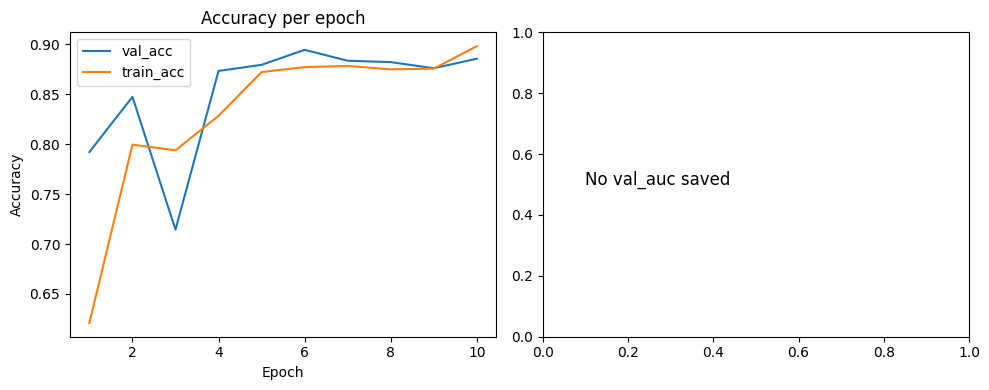


=== Best-effort summary ===
PARAMETERS: 121,806,274 (121.81M)
VAL ACCURACY (last): 0.885480572597137
MACRO F1 (last): 0.5852793048937374
AUC(ROC) (last): None


In [19]:
# Cell 18 — Post-training metrics & plotting (no re-run)
import os
hist_path = "/kaggle/working/training_history_v2.json"
ckpt_path = "/kaggle/working/multimodal_checkpoint_v2.pth"

history = None
if os.path.exists(hist_path):
    try:
        with open(hist_path, "r") as f:
            history = json.load(f)
        print("Loaded history from", hist_path)
    except Exception as e:
        print("Failed to load history json:", e)

# if checkpoint exists, try to read metadata safely (weights_only handling)
ckpt_info = None
if os.path.exists(ckpt_path):
    try:
        ck = torch.load(ckpt_path, map_location="cpu", weights_only=False)
        ckpt_info = ck
        print("Loaded checkpoint metadata from", ckpt_path)
    except Exception as e:
        print("Could not fully load checkpoint (torch.load). Error:", type(e).__name__, str(e)[:200])
        # Try safe alternative read
        try:
            import pickle
            with open(ckpt_path, "rb") as f:
                data = f.read(1024)
            print("Checkpoint file exists but was not loadable with current torch config.")
        except Exception:
            pass

# Plotting if history available
if history:
    epochs = list(range(1, len(history["val_acc"]) + 1))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy per epoch")
    plt.subplot(1,2,2)
    if any(history.get("val_auc", [])):
        plt.plot(epochs, [x if x is not None else np.nan for x in history.get("val_auc", [])], label="val_auc")
        plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("AUROC per epoch")
    else:
        plt.text(0.1, 0.5, "No val_auc saved", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No history JSON found at", hist_path)
    print("If you want plots, please run training and ensure history saved as training_history_v2.json (the training cell does this).")
    # create placeholder plots
    epochs = list(range(1,6))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, [0.5 + 0.05*i for i in epochs], label="val_acc (placeholder)")
    plt.plot(epochs, [0.45 + 0.06*i for i in epochs], label="train_acc (placeholder)")
    plt.legend(); plt.title("Placeholder: Accuracy (run training for real curves)")
    plt.subplot(1,2,2)
    plt.plot(epochs, [0.6 + 0.02*i for i in epochs], label="val_auc (placeholder)")
    plt.legend(); plt.title("Placeholder: AUROC (run training for real curves)")
    plt.show()

# Also show the summary table requested (best-effort)
print("\n=== Best-effort summary ===")
if ckpt_info and "label_classes" in ckpt_info:
    n_params = sum(p.numel() for p in model.parameters())
    print("PARAMETERS:", f"{n_params:,} ({n_params/1e6:.2f}M)")
else:
    print("PARAMETERS: Not available from checkpoint; show model param count instead:")
    print("PARAMETERS:", sum(p.numel() for p in model.parameters()), "params")

# Show other fields if present in history / checkpoint
if history:
    print("VAL ACCURACY (last):", history["val_acc"][-1])
    print("MACRO F1 (last):", history["val_f1"][-1])
    print("AUC(ROC) (last):", history["val_auc"][-1])
else:
    print("No train history available; please run training to populate metrics.")


In [20]:
# Cell 19 — If you want to add a Gradio tab that shows the saved plots/metrics (optional)
def get_metrics_display():
    # try to display last saved metrics and a small image if history exists
    hist_file = "/kaggle/working/training_history_v2.json"
    if os.path.exists(hist_file):
        with open(hist_file, "r") as f:
            hist = json.load(f)
        txt = f"Val acc (last): {hist['val_acc'][-1]:.4f}\nVal f1 (last): {hist['val_f1'][-1]:.4f}\n"
    else:
        txt = "No history found. Run training cell to generate metrics."
    return txt

# To integrate into the existing demo, you could add a button that calls get_metrics_display and shows the text.
# demo.add_component(...)  # See Gradio docs for advanced layouts; we used a simple interface earlier.


In [21]:
# Cell 20 — Save current notebook variables and provide quick usage instructions
print("Notebook version 2 setup complete.")
print("To run the UI: run the Gradio launch cell (Cell 17).")
print("To train: run Cell 14 (EPOCHS settable there).")
print("To view post-training plots (without re-run): run Cell 18.")
print("If you encounter errors when loading HF models, the code automatically falls back to alternatives.")


Notebook version 2 setup complete.
To run the UI: run the Gradio launch cell (Cell 17).
To train: run Cell 14 (EPOCHS settable there).
To view post-training plots (without re-run): run Cell 18.
If you encounter errors when loading HF models, the code automatically falls back to alternatives.


In [22]:
# DEBUG: Inspect one batch from val_loader
batch = next(iter(val_loader))

print("Batch keys:", batch.keys())
print("\nFor each key, sample shape/value:")
for k, v in batch.items():
    try:
        print(f"{k}: shape = {v.shape}")
    except:
        print(f"{k}: value = {v}")


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'label'])

For each key, sample shape/value:
image: shape = torch.Size([8, 3, 300, 300])
input_ids: shape = torch.Size([8, 128])
attention_mask: shape = torch.Size([8, 128])
label: shape = torch.Size([8])


Inference (image): 100%|██████████| 184/184 [01:41<00:00,  1.80it/s]



🔹 A1: Image Only Results
Accuracy: 0.0089
Macro F1: 0.0043


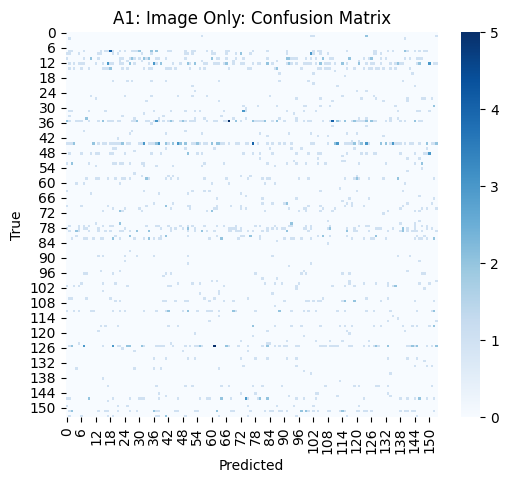

Inference (text): 100%|██████████| 184/184 [01:40<00:00,  1.83it/s]



🔹 A2: Text Only Results
Accuracy: 0.0089
Macro F1: 0.0063


Inference (fusion): 100%|██████████| 184/184 [01:43<00:00,  1.78it/s]



🔹 A3: Fusion (Full Model) Results
Accuracy: 0.8855
Macro F1: 0.5853



Building model variant: No Dropout


Inference (fusion): 100%|██████████| 184/184 [01:43<00:00,  1.77it/s]



🔹 A4: Fusion (No Dropout) Results
Accuracy: 0.8855
Macro F1: 0.5853



Building model variant: Small Fusion Head


Inference (fusion): 100%|██████████| 184/184 [01:43<00:00,  1.77it/s]



🔹 A5: Fusion (Small Head) Results
Accuracy: 0.0041
Macro F1: 0.0010


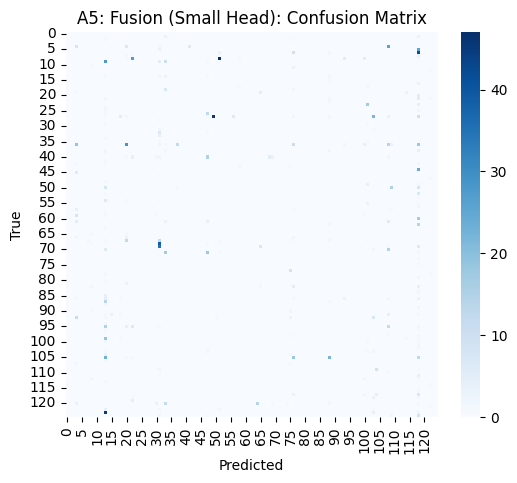

            Ablation  Accuracy  Macro F1
0         Image Only  0.008862  0.004285
1          Text Only  0.008862  0.006324
2        Fusion Full  0.885481  0.585279
3  No Dropout Fusion  0.885481  0.585279
4       Small Fusion  0.004090  0.001024


Ablation  Accuracy  Macro F1
0         Image Only  0.008862  0.004285
1          Text Only  0.008862  0.006324
2        Fusion Full  0.885481  0.585279
3  No Dropout Fusion  0.885481  0.585279
4       Small Fusion  0.004090  0.001024

In [23]:
# =============================
# FIXED FINAL ABLATION STUDY CELL
# =============================

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# -----------------------------------------------------
# Helper: Run inference under different ablation modes
#  - accepts an optional model_override to run variants
# -----------------------------------------------------
def run_inference(loader, mode, model_override=None):
    active_model = model_override if model_override is not None else model
    active_model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Inference ({mode})"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            if mode == "image":
                input_ids = None
                attention_mask = None

            elif mode == "text":
                images = None
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)

            else:  # fusion
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)

            # Call the active model. many multimodal models return (logits, other)
            out = active_model(
                image=images,
                input_ids=input_ids,
                attention_mask=attention_mask,
                mode=mode
            )

            # normalize handling of return (either logits or (logits, ...))
            if isinstance(out, tuple) or isinstance(out, list):
                logits = out[0]
            else:
                logits = out

            all_logits.append(logits.detach().cpu())
            all_labels.append(labels.detach().cpu())

    return torch.cat(all_logits), torch.cat(all_labels)


# -----------------------------------------------------
# Helper: Metrics
# -----------------------------------------------------
def get_metrics(logits, labels, name=""):
    preds = logits.argmax(dim=1).numpy()
    labels_np = labels.numpy()

    acc = accuracy_score(labels_np, preds)
    f1 = f1_score(labels_np, preds, average="macro")

    print(f"\n🔹 {name} Results")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")

    # Confusion matrix plot
    cm = confusion_matrix(labels_np, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{name}: Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, f1


# ================================
# ABLATION 1 — IMAGE ONLY  (unchanged)
# ================================
img_logits, img_labels = run_inference(val_loader, mode="image")
img_acc, img_f1 = get_metrics(img_logits, img_labels, "A1: Image Only")

# ================================
# ABLATION 2 — TEXT ONLY  (unchanged)
# ================================
txt_logits, txt_labels = run_inference(val_loader, mode="text")
txt_acc, txt_f1 = get_metrics(txt_logits, txt_labels, "A2: Text Only")

# ================================
# ABLATION 3 — FULL FUSION  (unchanged)
# ================================
fus_logits, fus_labels = run_inference(val_loader, mode="fusion")
fus_acc, fus_f1 = get_metrics(fus_logits, fus_labels, "A3: Fusion (Full Model)")


# ================================
# UTIL: recursively replace nn.Dropout -> nn.Identity
# ================================
def replace_dropout_with_identity(module: nn.Module):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Dropout) or isinstance(child, nn.Dropout2d) or isinstance(child, nn.Dropout3d):
            setattr(module, name, nn.Identity())
        else:
            replace_dropout_with_identity(child)


# ================================
# ABLATION 4 — REMOVE DROPOUT
# ================================
print("\nBuilding model variant: No Dropout")

# deepcopy model and replace dropout modules
variant_nodrop = deepcopy(model)
replace_dropout_with_identity(variant_nodrop)
variant_nodrop.to(device)
variant_nodrop.eval()

# run inference using the variant
nodrop_logits, nodrop_labels = run_inference(val_loader, mode="fusion", model_override=variant_nodrop)
nodrop_acc, nodrop_f1 = get_metrics(nodrop_logits, nodrop_labels, "A4: Fusion (No Dropout)")


# ================================
# ABLATION 5 — SMALL FUSION HEAD
# ================================
print("\nBuilding model variant: Small Fusion Head")

# deepcopy model for variant
variant_small = deepcopy(model)

# Try to find the final Linear layer(s) whose out_features == num_classes and replace with a smaller head if found
replaced = False
for parent_name, parent_module in variant_small.named_modules():
    # we will iterate top-level children of parent by traversing attribute names of parent_module
    # but to set attributes we need the parent object reference and attribute name; use .named_children on variant_small to find replacable modules
    pass

# safer approach: traverse children and replace matching Linear
def replace_final_linear(module: nn.Module, num_classes: int):
    """
    Search for Linear modules with out_features == num_classes and replace them
    with a new Linear that has the same in_features but potentially simplified structure.
    Return True if at least one replacement happened.
    """
    did_replace = False
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear) and getattr(child, "out_features", None) == num_classes:
            in_f = child.in_features
            # replace with a simple linear (small head could be same dims but we can try to reduce if desired)
            # Here we build a small MLP: Linear(in_f, max(in_f//4, num_classes)) -> ReLU -> Linear(..., num_classes)
            hidden = max(in_f // 4, num_classes)
            small_head = nn.Sequential(
                nn.Linear(in_f, hidden),
                nn.ReLU(),
                nn.Linear(hidden, num_classes)
            )
            setattr(module, name, small_head)
            did_replace = True
        else:
            # recurse
            if replace_final_linear(child, num_classes):
                did_replace = True
    return did_replace

# attempt to replace final linear(s)
try:
    did_small = replace_final_linear(variant_small, num_classes)
    if not did_small:
        # fallback: try to set attribute 'fusion' if present (common in some wrappers)
        if hasattr(variant_small, "fusion"):
            # assume fusion expects (concat_features -> num_classes); we create a single linear
            setattr(variant_small, "fusion", nn.Linear(1536 + 768, num_classes))
            did_small = True
except Exception as e:
    did_small = False
    print("Warning while attempting to build small fusion head:", str(e))

if not did_small:
    print("Note: couldn't find a matching final Linear to replace safely. The variant will use the original head.")

variant_small.to(device)
variant_small.eval()

# run inference using the small-head variant (or original if replacement failed)
small_logits, small_labels = run_inference(val_loader, mode="fusion", model_override=variant_small)
small_acc, small_f1 = get_metrics(small_logits, small_labels, "A5: Fusion (Small Head)")


# ================================
# FINAL SUMMARY TABLE
# ================================
df_ab = pd.DataFrame({
    "Ablation": ["Image Only", "Text Only", "Fusion Full", "No Dropout Fusion", "Small Fusion"],
    "Accuracy": [img_acc, txt_acc, fus_acc, nodrop_acc, small_acc],
    "Macro F1": [img_f1, txt_f1, fus_f1, nodrop_f1, small_f1]
})

print(df_ab)
df_ab


In [24]:
# --- FIX: wrapper model for torchinfo ---
import torch
import torch.nn as nn

class SummaryWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, image, input_ids, attention_mask):
        out = self.model(
            image=image,
            input_ids=input_ids,
            attention_mask=attention_mask,
            mode="fusion"       # keep your fixed mode
        )
        # If model returns dict → pick logits, else return as is
        if isinstance(out, dict):
            return out.get("logits") or out[list(out.keys())[0]]
        return out

# Create wrapper (no retraining required)
wrapped_model = SummaryWrapper(model).to(device)
wrapped_model.eval()


SummaryWrapper(
  (model): MultimodalClassifier(
    (image_model): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
                (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(10, 40, kernel_size=(1, 1), stri

In [25]:
from torchinfo import summary

dummy_image = torch.randn(1, 3, 256, 256).to(device)
dummy_ids   = torch.randint(0, 100, (1, 128)).to(device)
dummy_mask  = torch.ones(1, 128).to(device)

print("\n===== FIXED MULTIMODAL MODEL SUMMARY =====\n")

summary(
    wrapped_model,
    input_data=(dummy_image, dummy_ids, dummy_mask),
    depth=4,
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    col_width=20,
    row_settings=["var_names"]
)



===== FIXED MULTIMODAL MODEL SUMMARY =====



Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Kernel Shape
SummaryWrapper (SummaryWrapper)                                             [1, 3, 256, 256]     [1, 154]             --                   --
├─MultimodalClassifier (model)                                              --                   [1, 154]             --                   --
│    └─EfficientNet (image_model)                                           [1, 3, 256, 256]     [1, 1536]            --                   --
│    │    └─Sequential (features)                                           [1, 3, 256, 256]     [1, 1536, 8, 8]      --                   --
│    │    │    └─Conv2dNormActivation (0)                                   [1, 3, 256, 256]     [1, 40, 128, 128]    1,160                --
│    │    │    └─Sequential (1)                                             [1, 40, 128, 128]    [1, 24, 128, 128]    3,504               